<a href="https://colab.research.google.com/github/dmitriygorlov/Yandex.Practikum_Data_Science/blob/main/Module-03_03-Time-series/project-11_time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Прогнозирование заказов такси

Нужно построить модель для предсказания количество заказов такси на следующий час.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-модели-Linear" data-toc-modified-id="Обучение-модели-Linear-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение модели Linear</a></span></li><li><span><a href="#Обучение-модели-Catboost" data-toc-modified-id="Обучение-модели-Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение модели Catboost</a></span></li><li><span><a href="#Обучение-модели-LightGBM" data-toc-modified-id="Обучение-модели-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение модели LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Linear" data-toc-modified-id="Linear-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression

!pip install catboost
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загрузили библиотеки

In [2]:
data = pd.read_csv("https://code.s3.yandex.net/datasets/taxi.csv", index_col=[0], parse_dates=[0])
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Загрузили данные, поставили дату как индекс. У нас 26 496 строк и один признак - кол-во заказов (num_orders). У нас классический временной ряд, ресемплируем данные по одному часу, а также отсортируем данные для дальнейшего анализа.

In [3]:
data.sort_index(inplace = True)

df = data.resample("1H").sum()

display(df.head())

print(df.index.is_monotonic)

df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Подготовили данные, дополнительно проверили на монотонность (теперь уверенно можем сказать, что у нас представленны данные за полгода с 2018:03:01 по 2018:08:31). 

Теперь можем приступить к их анализу.

## Анализ

Для начала проведём визуальный анализ.

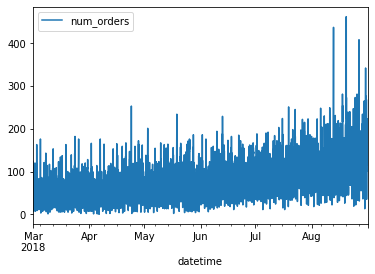

In [4]:
df.plot()

Визуально не видно особых зависимостей кроме увеличения количества заказов со временем. Проведём сезонную декомпозицию и проанализируем эти графики.

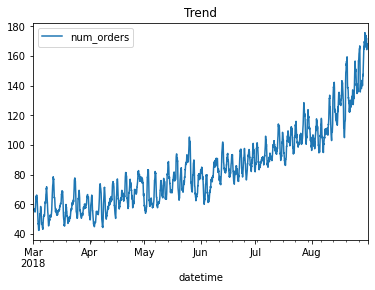

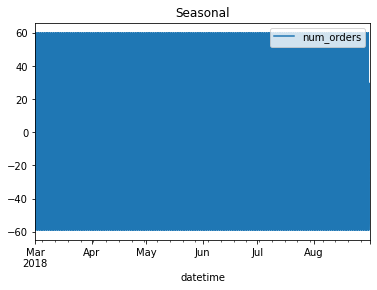

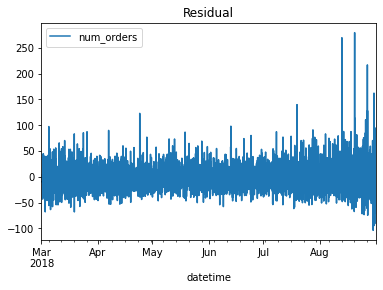

In [5]:
df_decompose = seasonal_decompose(df)

df_decompose.trend.plot(title = 'Trend')
plt.show()

df_decompose.seasonal.plot(title = 'Seasonal')
plt.show()

df_decompose.resid.plot(title = 'Residual')
plt.show()

по первичному визуальному анализу заметно следующее:
- Есть явный тренд на повышение количества заказов такси в ча за эти полгода
- Есть явная сезонность, но она не видна на таком масштабе (нужно ближе посмотреть, что сказать точнее)
- Остатки около нуляя и не несут в себе никакой струтуры

Посмотрим на сезонность ближе

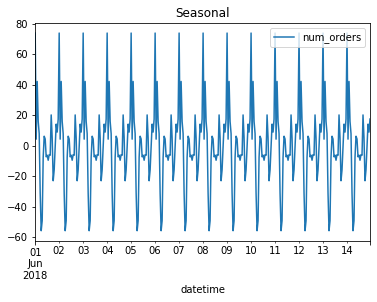

In [6]:
seasonal_decompose(df['2018-06-01':'2018-06-14']).seasonal.plot(title = 'Seasonal')
plt.show()

При близком рассмотрении можно заметить явную сезонность:
- Ночью заказывают меньше такси, затем идёт утреннее повышение, затем спад и вечершенее повышение, снова со спадом и к 12 идёт самый пик. Таким образом сезонность суточная, в нашем случае 24 строки (данные по часу берутся). **Максимальный лаг можем поставить равным 24**

## Обучение

Разделим обучение на 4 части:
- Создание признаков
- Обучение модели Linear
- Обучение модели Catboost
- Обучение модели LightGBM

### Создание признаков

Прежде чем переййти к обучению моделей, нам нужно создать признаки:
- Календарные признаки. Здесь всё просто, учитывая, что в наших данных полгода - возьмём день, день недели и месяц
- «Отстающие значения». Выше, благодаря визуальному анализу, мы нашли максимальный лаг и возьмём его равным 24
- Скользящее среднее. Тут сделаем небольшой цикл с помощью линейной регрессии (поскольку она быстрее всех) и вычислим лучшее значение

Для начала создадим функцию по созданию признаков

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
#     new_data['month'] = new_data.index.month
#     new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

Теперь пройдёмся циклом с помощью линейной регрессии и найдём лучшее q (шаг скользящей средней).

In [8]:
# создадим функцию rmse, чтобы сохрнаить лучший результат
def rmse(pred, real):
    rmse_value = mean_squared_error(pred, real) ** 0.5
    return rmse_value

best_rmse = 1000

for q in range (1, 100):
    df_variant = make_features(df, 24, q)
    
    df_variant.dropna(inplace = True)
    
    features = df_variant.drop('num_orders', axis = 1)
    target = df_variant['num_orders']
    
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.1, shuffle = False)
    
    model = LinearRegression()
    model.fit(features_train, target_train)

    model_pred = model.predict(features_test)
        
    model_rmse = rmse(model_pred, target_test)
    
    if model_rmse < best_rmse:
        best_rmse = model_rmse
        best_q = q

        
print('q:', best_q)
print("RMSE:", best_rmse)

q: 73
RMSE: 45.024869984472346


Итак, после подбора значений, лучшей RMSE будет с q = 73. Кроме того, мы уже нашли решение с удовлетворяющим RMSE исходя из условий задачи (меньше 48)

**Для создания признаков нужно взять p = 24 и q = 73**

In [9]:
best_df = make_features(df, 24, 73)

best_df.dropna(inplace = True)
    
features = best_df.drop('num_orders', axis = 1)
target = best_df['num_orders']
    
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.1, shuffle = False)

Признаки готовы, перейдём к моделям

### Обучение модели Linear

In [10]:
%%time

LINR = LinearRegression()

LINR.fit(features_train, target_train)

CPU times: user 9.73 ms, sys: 1.77 ms, total: 11.5 ms
Wall time: 10.3 ms


In [11]:
%%time
LINR_pred = LINR.predict(features_test)

CPU times: user 3.66 ms, sys: 1.73 ms, total: 5.39 ms
Wall time: 4.33 ms


In [12]:
print("RMSE LINEAR", rmse(target_test, LINR_pred))

RMSE LINEAR 45.024869984472346


В целом выше мы уже воспользовались моделью Линейной регресси и получили необходимо значение, повторили исключительно ради дальнейшего сравнения по времени. Перейдём к следующим моделям

### Обучение модели Catboost

Посмотрим несколько гиперпарамтеров

In [13]:
%%time
catboost = CatBoostRegressor()

tscv = TimeSeriesSplit(n_splits=8)

parametrs_cat = {'loss_function' : ['RMSE'],
             'iterations' : [200],
              'depth' : [10, 5],
              'learning_rate' : [0.8],
              'verbose' : [100],
              'random_state' : [12345]}
clf_cat = GridSearchCV(estimator = catboost, param_grid = parametrs_cat, cv = tscv)

clf_cat.fit(features_train, target_train)

print(clf_cat.best_params_)

0:	learn: 21.8797512	total: 93.9ms	remaining: 18.7s
100:	learn: 0.0003574	total: 3.46s	remaining: 3.39s
199:	learn: 0.0000000	total: 6.67s	remaining: 0us
0:	learn: 21.8067061	total: 40.3ms	remaining: 8.02s
100:	learn: 0.0111117	total: 3.83s	remaining: 3.75s
199:	learn: 0.0000091	total: 7.62s	remaining: 0us
0:	learn: 22.3039393	total: 43.7ms	remaining: 8.69s
100:	learn: 0.0561196	total: 4.15s	remaining: 4.06s
199:	learn: 0.0001368	total: 8.2s	remaining: 0us
0:	learn: 23.1053623	total: 47ms	remaining: 9.36s
100:	learn: 0.1199847	total: 4.38s	remaining: 4.29s
199:	learn: 0.0009234	total: 8.71s	remaining: 0us
0:	learn: 23.7275335	total: 50.5ms	remaining: 10s
100:	learn: 0.2723801	total: 4.7s	remaining: 4.61s
199:	learn: 0.0054165	total: 9.34s	remaining: 0us
0:	learn: 24.4683791	total: 50.1ms	remaining: 9.98s
100:	learn: 0.3869934	total: 4.88s	remaining: 4.79s
199:	learn: 0.0119509	total: 9.68s	remaining: 0us
0:	learn: 24.9371489	total: 59.9ms	remaining: 11.9s
100:	learn: 0.8203313	total: 5

Лучшая модель найдена, посмотрим её результат на тестовой части.

In [14]:
%%time
best_cat = CatBoostRegressor(loss_function = 'RMSE',
             iterations = 200,
              depth = 10,
              learning_rate = 0.8,
              verbose = 50,
              random_state = 12345)
best_cat.fit(features_train, target_train)

0:	learn: 27.6416239	total: 58.1ms	remaining: 11.6s
50:	learn: 5.2089807	total: 3s	remaining: 8.76s
100:	learn: 1.3281743	total: 5.86s	remaining: 5.75s
150:	learn: 0.3733669	total: 8.78s	remaining: 2.85s
199:	learn: 0.1063247	total: 11.7s	remaining: 0us
CPU times: user 22.2 s, sys: 200 ms, total: 22.4 s
Wall time: 11.7 s


In [15]:
%%time
best_cat_pred = best_cat.predict(features_test)

CPU times: user 4.84 ms, sys: 5.89 ms, total: 10.7 ms
Wall time: 11.2 ms


In [16]:
print("RMSE catboost", rmse(target_test, best_cat_pred))

RMSE catboost 48.121235897759284


Результат неплох (меньше требуемых 48), но попробуем и вторую модель

In [17]:
%%time
second_cat = CatBoostRegressor(loss_function = 'RMSE',
             iterations = 200,
              depth = 5,
              learning_rate = 0.8,
              verbose = 50,
              random_state = 12345)
second_cat.fit(features_train, target_train)

0:	learn: 28.7741580	total: 4.83ms	remaining: 960ms
50:	learn: 15.9075180	total: 224ms	remaining: 654ms
100:	learn: 11.9139564	total: 452ms	remaining: 443ms
150:	learn: 9.1706721	total: 677ms	remaining: 220ms
199:	learn: 7.2934805	total: 916ms	remaining: 0us
CPU times: user 1.7 s, sys: 79 ms, total: 1.78 s
Wall time: 978 ms


In [18]:
%%time
second_cat_pred = second_cat.predict(features_test)

CPU times: user 2.33 ms, sys: 2.97 ms, total: 5.31 ms
Wall time: 5.53 ms


In [19]:
print("RMSE catboost", rmse(target_test, second_cat_pred))

RMSE catboost 45.17272446798615


Результат вышел лучше и приемлемый для задачи (меньше 48), берём эту модель. Первая модель переобучилась, от неё отказываемся.

### Обучение модели LightGBM

In [20]:
%%time
LGBM = LGBMRegressor()
parametrs_LGBM = {'metric' : ['RMSE'],
                  'n_estimators' : [100],
              'depth' : [15, 10, 5],
              'learning_rate' : [0.8],
              'verbose' : [50],
              'random_state' : [12345]}
clf_LGBM = GridSearchCV(estimator = LGBM, param_grid = parametrs_LGBM, cv = tscv)

clf_LGBM.fit(features_train, target_train)

print(clf_LGBM.best_params_)

{'depth': 15, 'learning_rate': 0.8, 'metric': 'RMSE', 'n_estimators': 100, 'random_state': 12345, 'verbose': 50}
CPU times: user 11.8 s, sys: 448 ms, total: 12.2 s
Wall time: 7.17 s


Лучшая модель найдена, посмотрим на её результаты на тестовой выборке.

In [21]:
%%time
best_LGBM = LGBMRegressor(metric = 'RMSE',
            n_estimators = 100,
              depth = 15,
              learning_rate = 0.8,
              verbose = 50,
              random_state = 12345)
best_LGBM.fit(features_train, target_train)

CPU times: user 606 ms, sys: 19.5 ms, total: 626 ms
Wall time: 347 ms


In [22]:
%%time
best_LGBM_pred = best_LGBM.predict(features_test)

CPU times: user 8.91 ms, sys: 950 µs, total: 9.86 ms
Wall time: 6.02 ms


In [23]:
print('RMSE LGBM', rmse(target_test, best_LGBM_pred))

RMSE LGBM 46.789997407039905


RMSE лучшей модели LGBM также устраивает по условию (RMSE меньше 48), но хуже остальных. Возьмём её как третью модель.

**Мы провели все обучения, теперь в рамках тестирования предскажем весь ряд и визуализируем предсказанные значения и реальные**

## Тестирование

### Linear

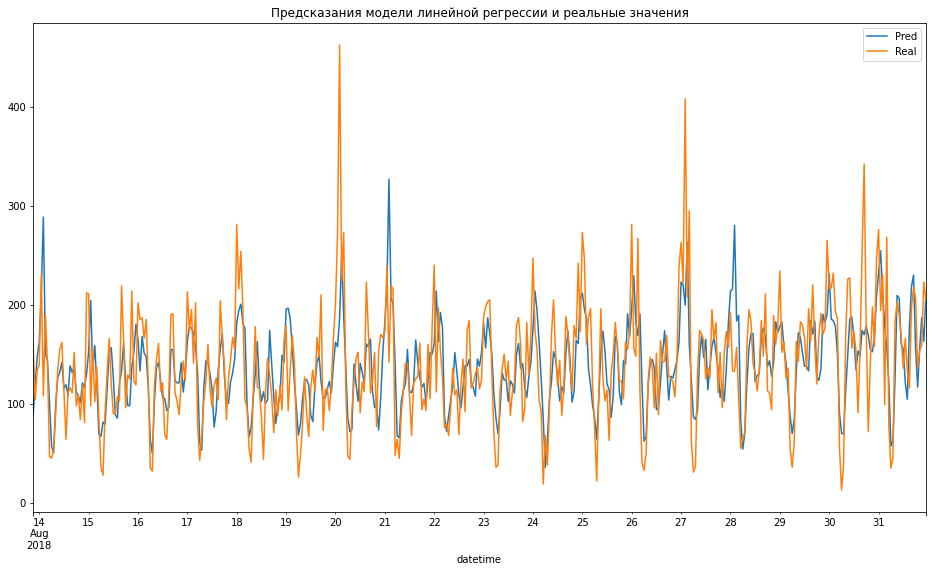

RMSE: 45.024869984472346
Время обучения: 25.2 ms
Время предсказания: 117 ms


In [24]:
Linear_df = pd.DataFrame({'Pred' : LINR_pred, 'Real' : target_test}, index = target_test.index)

Linear_df.plot(title = 'Предсказания модели линейной регрессии и реальные значения', figsize = (16, 9))
plt.show()

print("RMSE:", rmse(target_test, LINR_pred))
print('Время обучения:', 25.2, 'ms')
print('Время предсказания:', 117, 'ms')

### Catboost

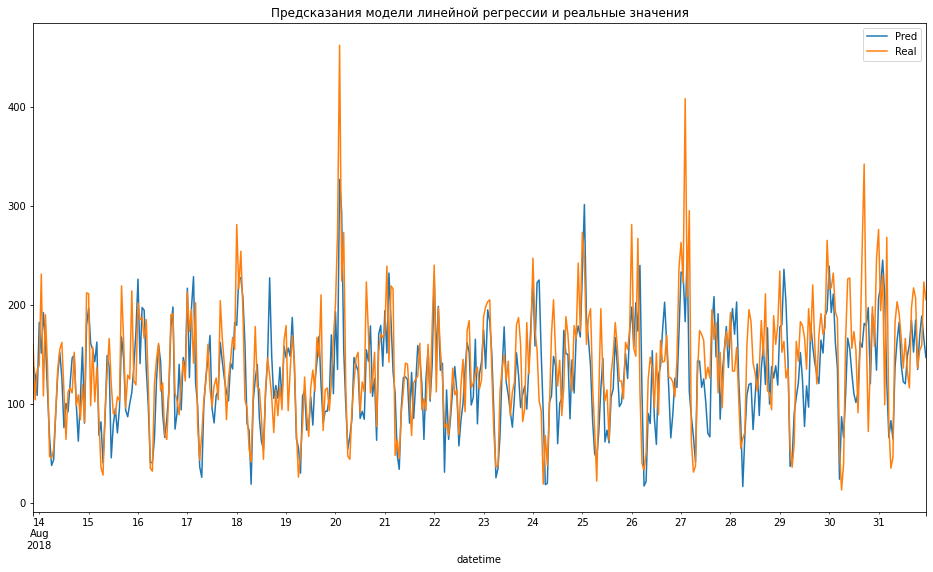

RMSE: 45.17272446798615
Время обучения: 4.24 s
Время предсказания: 8.88 ms


In [25]:
Catboost_df = pd.DataFrame({'Pred' : second_cat_pred, 'Real' : target_test}, index = target_test.index)

Catboost_df.plot(title = 'Предсказания модели линейной регрессии и реальные значения', figsize = (16, 9))
plt.show()

print("RMSE:", rmse(target_test, second_cat_pred))
print('Время обучения:', 4.24, 's')
print('Время предсказания:', 8.88, 'ms')

### LGBM

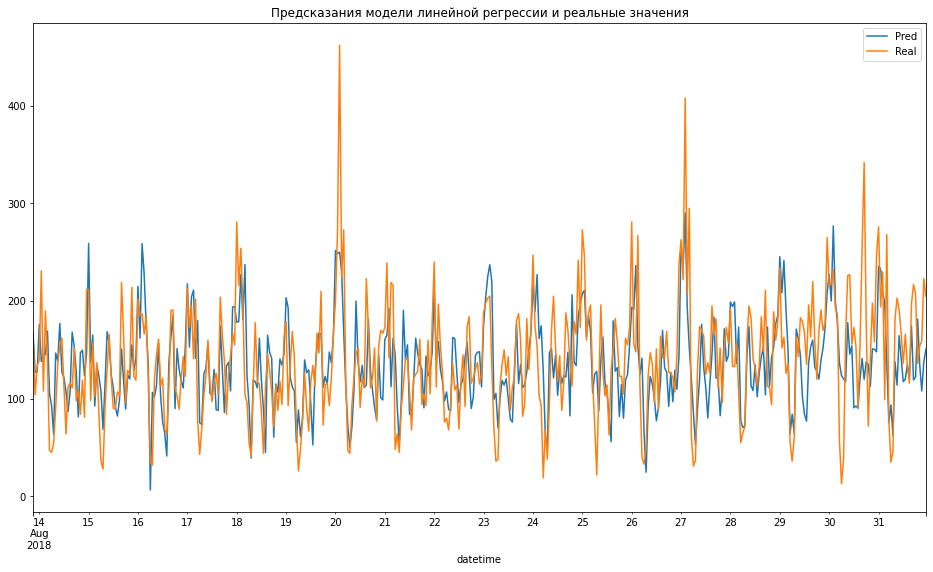

RMSE: 46.789997407039905
Время обучения: 1.81 s
Время предсказания: 53.4 ms


In [26]:
LGBM_df = pd.DataFrame({'Pred' : best_LGBM_pred, 'Real' : target_test}, index = target_test.index)

LGBM_df.plot(title = 'Предсказания модели линейной регрессии и реальные значения', figsize = (16, 9))
plt.show()

print("RMSE:", rmse(target_test, best_LGBM_pred))
print('Время обучения:', 1.81, 's')
print('Время предсказания:', 53.4, 'ms')

На графиках в целом можно заметить, как Catboost показывает не только лучший RMSE, но и лучше других пытается предсказать выбросы, поэтому считаем эту модель лучшей по результатам теста.

## Вывод

**Лучшая модель для нашего предсказания - это модель Catboost. Она показала лучший RMSE: 44.47. Второй с очень близким значением RMSE (45.02) стала модель Линейной регресии. Она куда быстрее обучалась и предсказывала, поэттому в случае дополнительных требований по скорости - можно использовать и её.**

Для моделей мы создали дополнительные признаки: Календарные (день недели, час дня); "Отстающие значение" (p = 24 - сезонности суток) и Скользящее среднее (q = 73, подобрали лучшее значение исходя из результатов линейной регресии).

Также важно заметить, чо в данных наблюдается явный тренд по увеличению количества заказов, это тоже стоит учитывать!